# Generate Fake-Faces using DCGAN

## Introduction

In this article, we'll explore the concept of Deep Convolutional Generative Adversarial Networks (DCGANs). DCGANs are a class of deep learning models introduced by Radford et al. in 2015. They are a powerful and widely-used approach for generating realistic synthetic images. DCGANs leverage the adversarial training framework to train a generator network to produce images that are indistinguishable from real images, and a discriminator network to distinguish between real and fake images.

We will train a generative adversarial network (GAN) to generate images of celebrities after being trained on a dataset containing pictures of real celebrities. The code presented here is based on the DCGAN implementation available in the official PyTorch examples repository. Throughout this tutorial, we will provide a comprehensive explanation of the implementation details, offering insights into how and why this model functions as it does.

No prior knowledge of GANs is necessary to follow along, although it may require some time to understand the underlying concepts. Additionally, having access to a GPU can significantly speed up the training process. Let's dive into the tutorial and explore DCGANs from the ground up.

## Generative Adversarial Networks

### What is a GAN?

GANs, introduced by Ian Goodfellow in 2014, consist of two models: a generator and a discriminator. The generator generates fake images resembling the training data, while the discriminator distinguishes between real and fake images. During training, the generator aims to outsmart the discriminator by generating better fakes, while the discriminator strives to correctly classify real and fake images. The equilibrium occurs when the generator produces perfect fakes and the discriminator cannot reliably distinguish between real and fake images.

Notation:
- $x$ represents real image data, and $D(x)$ is the discriminator's output probability that $x$ is real.
- $z$ is a latent space vector sampled from a normal distribution, and $G(z)$ maps it to data-space, generating fake images.
- $D(G(z))$ is the probability that the output of the generator is a real image.

The GAN loss function, as defined by Goodfellow, is:

$$
\underset{G}{\text{min}} \underset{D}{\text{max}} V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]
$$

In this equation, $p_g = p_{data}$ indicates convergence, where the generator perfectly mimics the data distribution, and the discriminator guesses randomly. However, achieving this ideal state is challenging, and GAN convergence remains an area of active research.

### What is a DCGAN?

A DCGAN extends the basic GAN architecture by incorporating convolutional and convolutional-transpose layers in the discriminator and generator, respectively. This approach was first introduced by Radford et al. in their paper "Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks." 

The discriminator consists of strided convolutional layers, batch normalization layers, and LeakyReLU activations. It takes a 3x64x64 input image and outputs a scalar probability indicating whether the input is from the real data distribution.

On the other hand, the generator comprises convolutional-transpose layers, batch normalization layers, and ReLU activations. It takes a latent vector $z$ drawn from a standard normal distribution and outputs a 3x64x64 RGB image. The use of strided conv-transpose layers allows the latent vector to be transformed into a volume with the same shape as an image.

In their paper, the authors provide guidelines on setting up optimizers, calculating loss functions, and initializing model weights, all of which will be covered in the subsequent sections.


## Prerequisites
To follow along with this article, you should have a basic understanding of:

- Python programming language
- PyTorch library
- Deep learning concepts, including convolutional neural networks (CNNs) and generative adversarial networks (GANs)

## Steps

### 1. Import Libraries

First, we need to import the necessary libraries:

In [7]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 41                               # Set random seed for reproducibility
#manualSeed = random.randint(1, 10000)        # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)      # Needed for reproducible results

Random Seed:  41


### 2. Define Generator and Discriminator Networks

We'll define the architecture for both the generator and discriminator networks.

### Generator

The generator, $G$, is designed to map the latent space vector($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training. An
image of the generator from the DCGAN paper is shown below.

.. figure:: /_static/img/dcgan_generator.png
   :alt: dcgan_generator

Notice, how the inputs we set in the input section (``nz``, ``ngf``, and
``nc``) influence the generator architecture in code. ``nz`` is the length
of the z input vector, ``ngf`` relates to the size of the feature maps
that are propagated through the generator, and ``nc`` is the number of
channels in the output image (set to 3 for RGB images). Below is the
code for the generator.

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### 3. Set Hyperparameters

Set hyperparameters such as batch size, learning rate, number of epochs, etc. Then, load the dataset.

In [10]:
# Hyperparameters
dataroot = "D:/08_Datasets/celeba"          # Root directory for dataset
workers = 2                                 # Number of workers for dataloader
batch_size = 128                            # Batch size during training
image_size = 64                             # All images will be resized to this size using a transformer
nc = 3                                      # Number of channels in the training images
nz = 100                                    # Size of the latent vector (i.e. size of generator input)
ngf = 64                                    # Number of generator filters (feature maps)
ndf = 64                                    # Number of discriminator filters (feature maps)
num_epochs = 5                              # Number of training epochs
lr = 0.0002                                 # Learning rate for optimizers
beta1 = 0.5                                 # Beta1 hyperparameter for Adam optimizers
ngpu = 1                                    # Number of GPUs available. Use 0 for CPU mode.

In this tutorial we will use the [Celeb-A Faces dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which can be downloaded at the linked site, or in [Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ). The dataset will download as a file named ``img_align_celeba.zip``. Once downloaded, create a directory named ``celeba`` and extract the zip file into that directory. Then, set the ``dataroot`` input for this notebook to the ``celeba`` directory you just created. The resulting directory structure should be:

```
/path/to/celeba
    -> img_align_celeba  
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...
```

### 4. Load Data

In [11]:
# # Load the dataset
# transform = transforms.Compose([
#     transforms.Resize(64),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

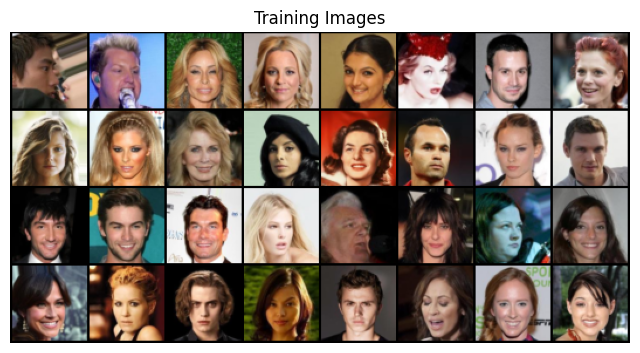

In [14]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### 4. Initialize Networks, Optimizers, and Loss Function

In [ ]:
# Initialize generator and discriminator
generator = Generator(nz, ngf, nc)
discriminator = Discriminator(nc, ndf)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

In [ ]:
# Define loss function and optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

### 5. Training Loop

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label_real = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output_real = discriminator(real_images).view(-1)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()
        D_x = output_real.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = generator(noise)
        label_fake = torch.full((b_size,), 0, dtype=torch.float, device=device)
        output_fake = discriminator(fake_images.detach()).view(-1)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update generator: maximize log(D(G(z)))
        generator.zero_grad()
        label_real = torch.full((b_size,), 1, dtype=torch.float, device=device)  # Generator wants discriminator to think that the generated images are real
        output_fake = discriminator(fake_images).view(-1)
        errG = criterion

In [ ]:
# #%matplotlib inline
# import argparse
# import os
# import random
# import torch
# import torch.nn as nn
# import torch.nn.parallel
# import torch.optim as optim
# import torch.utils.data
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import HTML

# # Set random seed for reproducibility
# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

### Weight Initialization

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with ``mean=0``, ``stdev=0.02``. The ``weights_init`` function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [15]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

### Discriminator

As mentioned, the discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
$G$ and $D$.




Discriminator Code



Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

### Loss Functions and Optimizers

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
([BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)_)
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from the [Goodfellow’s paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)_, 
while abiding by some of the best
practices shown in [ganhacks](https://github.com/soumith/ganhacks)_.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$log(D(G(z)))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from [ganhacks](https://github.com/soumith/ganhacks)_,
we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the ``BCELoss`` (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

To save and load the trained models in PyTorch, you can use the torch.save() function to save the model's state dictionary and other necessary information to a file, and then use torch.load() to load the model back from that file. Here's how you can save and load the trained Generator (netG) and Discriminator (netD) models in your code:

Save trained models:

In [ ]:
# Save Generator and Discriminator models
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

In [ ]:
# Load the model

In [ ]:
# Define Generator and Discriminator models (assuming you have defined them already)
# For instance, you may have:
# netG = Generator()
# netD = Discriminator()

# Load Generator and Discriminator models
netG.load_state_dict(torch.load('generator.pth'))
netD.load_state_dict(torch.load('discriminator.pth'))

# Set models to evaluation mode
netG.eval()
netD.eval()


In [ ]:
# Generate fake images
num_images = 64  # Number of fake images to generate
fixed_noise = torch.randn(num_images, nz, 1, 1, device=device)  # Assuming nz is the size of the latent vector
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()

## Results

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=5, normalize=True), (1, 2, 0)))
# plt.imshow(np.transpose(fake_images[:64],(1,2,0)))
plt.show()

## Where to Go Next

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   [here](https://github.com/nashory/gans-awesome-applications)_
-  Create GANs that generate
   [music](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio/)_


